In [1]:
# https://keras.io/examples/vision/supervised-contrastive-learning/

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
#from tensorflow.keras import layers

In [23]:
from tensorflow import keras

img_size = (64, 64)

dataset = keras.preprocessing.image_dataset_from_directory(
                "datasets_new/Multiband_Brodatz_Texture", 
                image_size = (64, 64), 
                #subset="training",
                #validation_split=0.2,
                batch_size = 1,
                seed = 1234,
                shuffle=True
                )

Found 39424 files belonging to 154 classes.


In [24]:
n_classes = len(dataset.class_names)
#n_samples = len(dataset.file_paths)
n_samples = len(dataset) * 1
n_batches = len(dataset)

print("n_classes = ", n_classes)
print("n_samples = ", n_samples)
print("n_batches = ", n_batches)

n_classes =  154
n_samples =  39424
n_batches =  39424


In [25]:
#
#    80% (training) + 20% (test)
#
# we keep 80% of the dataset as training
n_training_batches = np.int(0.8 * n_batches)
dataset_training = dataset.take(n_training_batches)

# we keep 10% of the dataset as testing
n_testing_batches = n_batches - n_training_batches
dataset_testing = dataset.skip(n_training_batches).take(n_testing_batches)

print("n_training_batches = ", n_training_batches)
print("n_testing_batches = ", n_testing_batches)

n_training_batches =  31539
n_testing_batches =  7885


In [26]:
import numpy as np
import pandas as pd
import os
import sys 

libpath = "lib"
sys.path.append(libpath)

In [27]:
if "split_keras_dataset_to_xy" in sys.modules:
    del sys.modules["split_keras_dataset_to_xy"]

from split_keras_dataset_to_xy import split_keras_dataset_to_xy

In [28]:
x_train, y_train = split_keras_dataset_to_xy(dataset_training)

data_shape =  (64, 64, 3)
X.shape =  (31539, 64, 64, 3)
y.shape =  (31539,)


In [29]:
x_test, y_test = split_keras_dataset_to_xy(dataset_testing)

data_shape =  (64, 64, 3)
X.shape =  (7885, 64, 64, 3)
y.shape =  (7885,)


In [10]:
# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (31539, 128, 128, 3) - y_train shape: (31539,)
x_test shape: (7885, 128, 128, 3) - y_test shape: (7885,)


In [30]:
num_classes = 154
input_shape = (64, 64, 3)

In [53]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

In [54]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    
    #augmented = data_augmentation(inputs)
    #outputs = resnet(augmented)
    
    outputs = resnet(inputs)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-encoder")
    return model


encoder = create_encoder()
encoder.summary()



Model: "cifar10-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


In [55]:
learning_rate = 0.001
#batch_size = 265
batch_size = 32

hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

In [56]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model

In [57]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()



Model: "cifar10-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
cifar10-encoder (Functional) (None, 2048)              23564800  
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 154)               79002     
Total params: 24,692,890
Trainable params: 24,647,450
Non-trainable params: 45,440
_______________________________

In [47]:
len(y_train)

31539

In [49]:
len(x_train)

31539

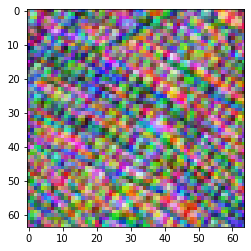

In [51]:
import matplotlib.pyplot as plt
plt.imshow(np.uint8(x_train[0]))
plt.show()

In [59]:
history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

In [ ]:
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

# 

In [60]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="cifar-encoder_with_projection-head"
    )
    return model

In [61]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()



Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
cifar10-encoder (Functional) (None, 2048)              23564800  
_________________________________________________________________
dense_12 (Dense)             (None, 128)               262272    
Total params: 23,827,072
Trainable params: 23,781,632
Non-trainable params: 45,440
_________________________________________________________________


In [66]:
history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, 
    batch_size=128, #batch_size, 
    epochs=num_epochs
)

Epoch 1/50
  2/247 [..............................] - ETA: 25:06 - loss: 3.1780

KeyboardInterrupt: 

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")